In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import matplotlib.patches as mpatches

In [2]:
from src.Patient import *
from src.data_pipeline import * 

In [3]:
c_palette = sns.color_palette("ch:s=.25,rot=-.25")

### Data Cleaning 

(see src/data_pipeline.py) 

In [4]:
#raw data
raw = pd.read_csv('../data/phq_all_final.csv')

#run through src.data_pipeline to get 3 tables
date_cols = ['date', 'patient_date_created']
groupby_cols = ['date', 'patient_id', 'patient_date_created']
id_col = 'patient_id'
val_col = 'score'
date_col = 'date'

df = clean_dataframe(raw, date_cols, groupby_cols, 
                        val_col, id_col, 
                        date_col)
diffs_df = get_diffs(df, index = 'num_visit', 
                        columns = 'patient_id', values = 'score')

merged_df = merge_scores_and_diffs(df, diffs_df, 
                            left_on=['patient_id', 'num_visit'], 
                            right_on=['patient_id', 'num_visit'])

### Initial Visualizations

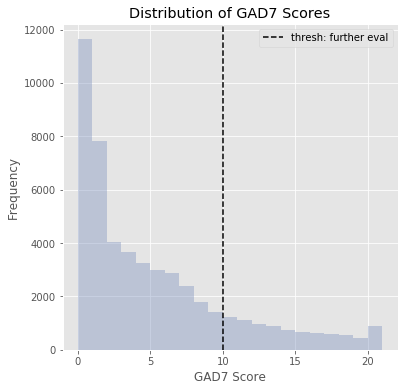

In [5]:
fig, ax = plt.subplots(figsize = (6,6))
ax.hist(df.score, bins = 21, alpha = 0.4, color = c_palette[2])
ax.set_xlabel('GAD7 Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of GAD7 Scores')
ax.axvline(x = 10, linestyle = 'dashed', color = 'k', label = 'thresh: further eval')
ax.legend();
# fig.savefig('images/score_dist.png')

Take a look at the total number of visits for each patient: 

In [7]:
total_visits = agg_into_series(df, 'patient_id', 'max', 'num_visit')

qt_95, qt_97_5, qt_99 = np.percentile(total_visits.num_visit, [95, 97.5, 99])

print(f'95% patients have had {qt_95} or fewer appointments')
print(f'97.5% patients have had {qt_97_5} or fewer appointments')
print(f'99% patients have had {qt_99} or fewer appointments')

95% patients have had 7.0 or fewer appointments
97.5% patients have had 8.0 or fewer appointments
99% patients have had 10.0 or fewer appointments


For visualizing improvement across all patients (overall trends), take a look at 0-10 visits, since it captures 99% of patients 

In [8]:
visits_subset = df[df['num_visit']<=10]

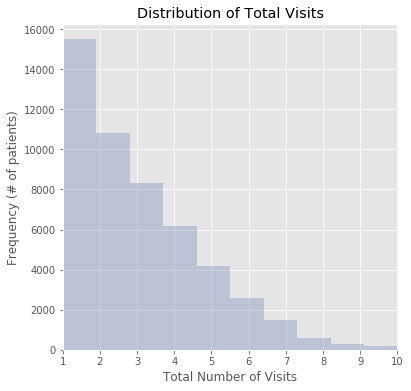

In [9]:
fig, ax = plt.subplots(figsize = (6,6))
ax.hist(visits_subset.num_visit, alpha = 0.4, color = c_palette[2], bins = 10)
ax.set_xlabel('Total Number of Visits')
ax.set_ylabel('Frequency (# of patients)')
ax.set_title('Distribution of Total Visits')
ax.set_xlim(1,10);
# fig.savefig('images/total_visits_hist.png');

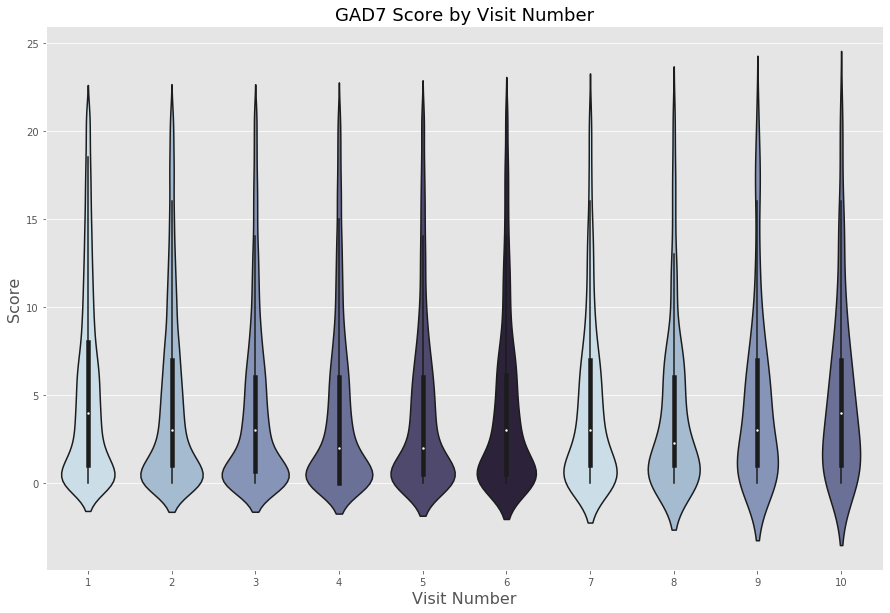

In [10]:
fig, ax = plt.subplots(figsize = (15,10))
sns.violinplot(visits_subset.num_visit, visits_subset.score, ax = ax, palette = c_palette)
ax.set_xlabel('Visit Number', fontsize = 16)
ax.set_ylabel('Score', fontsize = 16)
ax.set_title('GAD7 Score by Visit Number', fontsize = 18);
# fig.savefig('images/score_by_visit_number_violin.png');

Compare the 1st, 2nd 4th, and 6th visits

In [11]:
#look at only patient ids who have made it to 6th visit
patients_with_6_visits = pd.DataFrame(df.patient_id[df.num_visit == 6])
patients_with_6_visits = pd.merge(patients_with_6_visits, df, left_on = 'patient_id', right_on='patient_id')

first_visit = patients_with_6_visits[patients_with_6_visits.num_visit == 1]
second_visit = patients_with_6_visits[patients_with_6_visits.num_visit == 2]
fourth_visit = patients_with_6_visits[patients_with_6_visits.num_visit == 4]
sixth_visit = patients_with_6_visits[patients_with_6_visits.num_visit == 6]

comparison = patients_with_6_visits[(patients_with_6_visits.num_visit == 6) | 
                                    (patients_with_6_visits.num_visit == 1) |
                                    (patients_with_6_visits.num_visit == 4) |
                                    (patients_with_6_visits.num_visit == 2)]


Text(0.5, 1.0, 'GAD7 Score after 1, 2, 4, and 6 Visits')

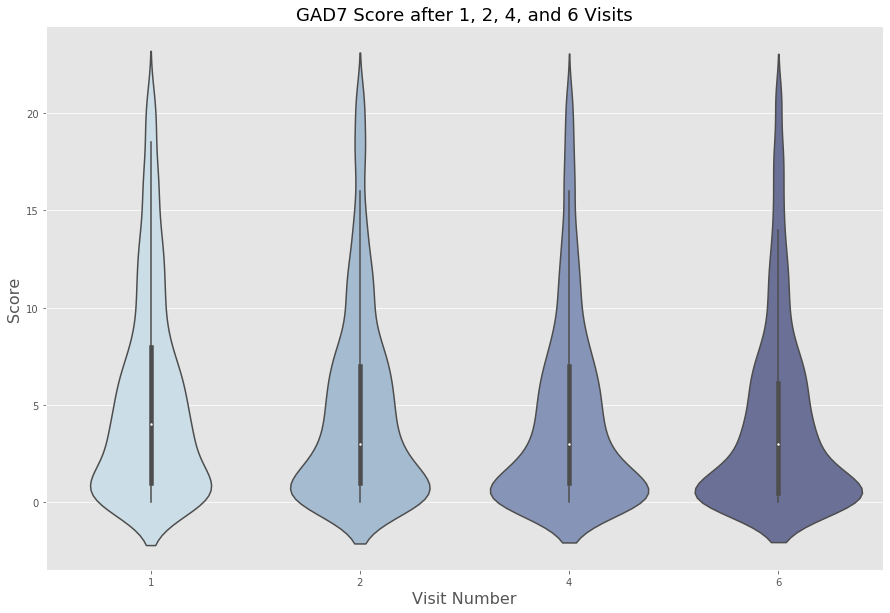

In [12]:
fig, ax = plt.subplots(figsize = (15,10))
sns.violinplot(comparison.num_visit, comparison.score, ax = ax, palette = c_palette)
ax.set_xlabel('Visit Number', fontsize = 16)
ax.set_ylabel('Score', fontsize = 16)
ax.set_title('GAD7 Score after 1, 2, 4, and 6 Visits', fontsize = 18)
# fig.savefig('images/score_by_visit_number_1246_violin.png');


In [13]:
def plot_empirical_data(ax, df, column, label = None, color = 'blue'):
    '''
        Plots the approximate cumulative distribution of a sample. 
            Parameters:
                    ax: axes object (matplotlib.pyplot)
                    df (pandas dataframe)
                    column (string): column name within dataframe that contains the data
                    label (string): label for plot
            Returns:
                    A line plot of the sample's cumulative distribution.
    '''    
    
    x = np.arange(df[column].min(), df[column].max()+1)
    y = ([df[df[column]<=xx][column].sum() for xx in x])/(df[column]).sum()
    data = np.hstack([x,y]).reshape(-1, len(x))
    ax.plot(data[0], data[1], label = label, color = color)

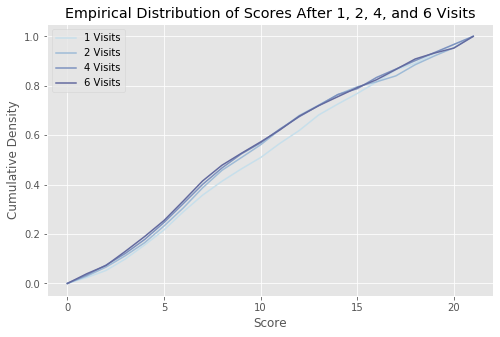

In [14]:
fig, ax = plt.subplots(figsize = (8,5))
visit_counts = [1, 2, 4, 6]

for idx, visit in enumerate(visit_counts):
    plot_empirical_data(ax, comparison[comparison.num_visit == visit],
                        'score', color = c_palette[idx], 
                       label = f'{visit} Visits')
ax.set_title('Empirical Distribution of Scores After 1, 2, 4, and 6 Visits')
ax.set_xlabel('Score')
ax.set_ylabel('Cumulative Density')
ax.legend();
# fig.savefig('images/empirical_distribution_scores_visits.png')

Let's look at when patients "exit" the program

Mental health is fluid, which makes labeling patients very difficult. 

It would be interesting to look at those patients who discontinue their sessions because they feel they no longer require therapy.  I think patterns in these patients' scores might be an interesting way to determine the best metric for measuring improvement.  For example, if most patients who discontinue therapy have 3 consecutive scores less than 5, maybe it's worth measuring that in all patients.


### Delta Scores

Look into the changes in scores between sequential visits

In [15]:
#adding a column for absolute change in score
diffs_df['absolute_delta'] = np.abs(diffs_df['delta_score'])

In [16]:
#90% of patients' deltas from prev assessment fall within following limits
warning_low = np.percentile(diffs_df['delta_score'], 5)
warning_high = np.percentile(diffs_df['delta_score'], 95)

#90% of patients' absolute deltas from prev assessment fall below following limit
warning_high_abs = np.percentile(diffs_df['absolute_delta'], 90)

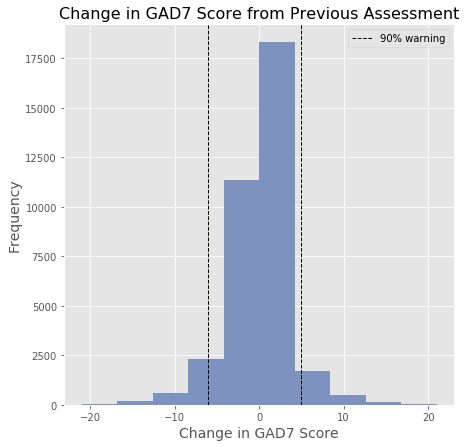

In [17]:
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(diffs_df['delta_score'], color = c_palette[2])
ax.axvline(x = warning_low, linewidth = 1, linestyle = 'dashed', color = 'k')
ax.axvline(x = warning_high, linewidth = 1, linestyle = 'dashed', color = 'k', label = '90% warning')
ax.set_xlabel('Change in GAD7 Score', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Change in GAD7 Score from Previous Assessment', fontsize = 16)
ax.legend();
# fig.savefig('images/delta_scores_hist.png');

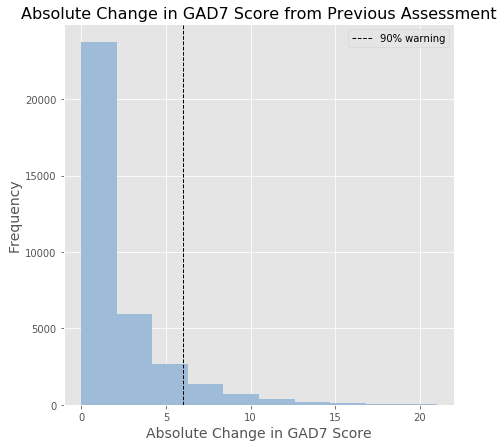

In [18]:
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(diffs_df['absolute_delta'], color = c_palette[1])
ax.axvline(x = warning_high_abs, linewidth = 1, linestyle = 'dashed', color = 'k', label = '90% warning')
ax.set_xlabel('Absolute Change in GAD7 Score', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Absolute Change in GAD7 Score from Previous Assessment', fontsize = 16)
ax.legend();
# fig.savefig('images/abs_delta_scores_hist.png');

### Consistency in Scores by Number of Visits

In [19]:
#color by whether raw score was >=10 (requiring further eval)
merged_df['further_eval'] = np.where(merged_df['score']>=10, 'Y', 'N')
color = np.where(merged_df.further_eval == 'N', 'lightsteelblue', 'steelblue')

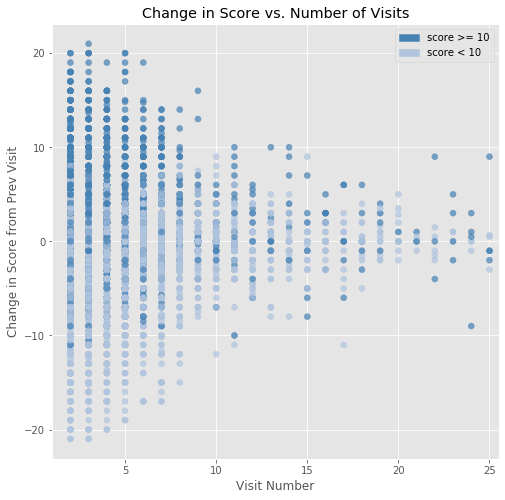

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
colax = ax.scatter(merged_df['num_visit'], merged_df['delta_score'], alpha = 0.7, color = color)
ax.set_xlabel('Visit Number')
ax.set_ylabel('Change in Score from Prev Visit')
ax.set_xlim(1, 25.5)
ax.set_title('Change in Score vs. Number of Visits')

eval_patch = mpatches.Patch(color='steelblue', label='score >= 10')
no_eval_patch = mpatches.Patch(color='lightsteelblue', label='score < 10')
ax.legend(handles=[eval_patch, no_eval_patch]);

# fig.savefig('images/change_score_by_visit.png');

Look at the two patients with higher changes in scores around visit 22 and 25 

In [21]:
merged_df[(merged_df.delta_score>=6)&(merged_df.num_visit>20)]

,date,patient_id,patient_date_created,score,num_visit,month,year,month_year,simulated_age,index,delta_score,further_eval
5178,2020-01-24,1867,2020-01-24,19.0,22,1,2020,2020-01,29,111765.0,9.0,Y
5181,2020-02-15,1867,2020-02-15,19.0,25,2,2020,2020-02,29,111768.0,9.0,Y


/Users/jamiewessels/job/nflow/nf-take-home/src/Patient.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


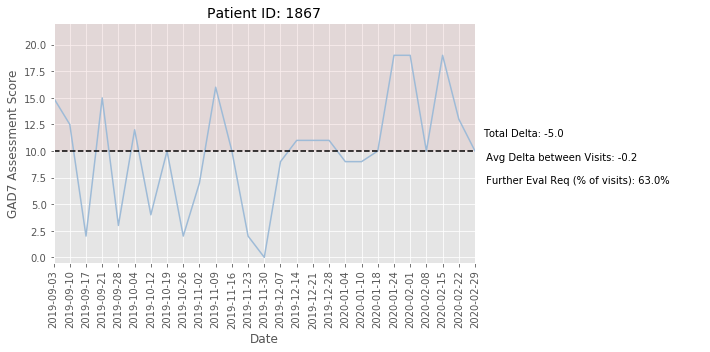

In [22]:
p1867 = Patient(1867)
p1867.plot_progress();

In [23]:
p1867.print_patient_stats()

initial_score: 15.0
final_score: 10.0
avg_delta: -0.2
total_change: -5.0
pct_further_eval: 63.0


#### Age Effect

I simulated an age column using a normal distribution centered at 30 years old and a sigma of 5 years.  It would be interesting to see if age had an effect on assessment score, to identify more at-risk patients.

I did not have time to further look into this.

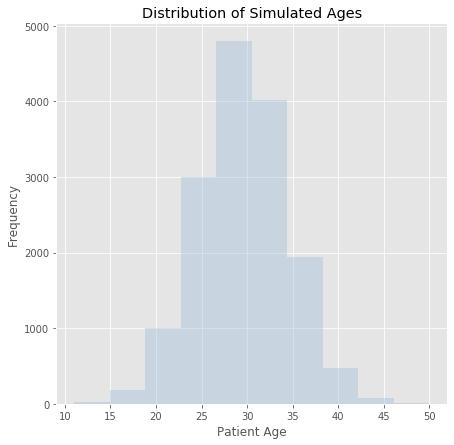

In [24]:
ages = df.drop_duplicates(['patient_id','simulated_age'])

fig, ax = plt.subplots(figsize = (7, 7))
ax.hist(ages.simulated_age, color = c_palette[1], alpha = 0.4)
ax.set_title('Distribution of Simulated Ages')
ax.set_xlabel('Patient Age')
ax.set_ylabel('Frequency');
# fig.savefig('images/simulated_ages_dist.png');

#### Seasonality

Before looking into any seasonal effects, it's important to look at any confounding factors, such as number of visits each month. It's also important to consider the fact that there was a spike during April 2020, during peak of pandemic. Need more than 1 year to look at seasonal trends.

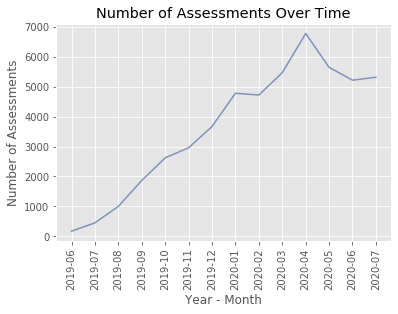

In [25]:
cnts_mmyy = df.groupby('month_year').count().reset_index()

fig, ax = plt.subplots()
x = np.arange(len(cnts_mmyy.month_year))
sns.lineplot(x, cnts_mmyy.year, ax = ax, color = c_palette[2])
ax.set_xticks(x)
ax.set_xticklabels(rotation = 90, labels = cnts_mmyy.month_year)
ax.set_title('Number of Assessments Over Time')
ax.set_xlabel('Year - Month')
ax.set_ylabel('Number of Assessments');
# fig.savefig('images/num_assessments_over_time.png');